## Q-performance comparison

In [1]:
import sys
import os 
sys.path.append('..')
sys.path.append('../..')
sys.path.append('../../..')

from learning.collections_env.collections_env import CollectionsEnv, MAX_ACCOUNT_BALANCE
from learning.utils.wrappers import DiscretizedActionWrapper, StateNormalization
from learning.policies.dqn import DQNAgent, DefaultConfig
from learning.utils import misc
from learning.policies.discrete_optimal_policy import DiscretePolicyConstructor
from dcc import Parameters, AAV, OAV


import numpy as np
import pickle
import copy
from itertools import product
#import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K


from IPython.display import HTML, clear_output

import matplotlib.pyplot as plt
# import seaborn as sns

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from learning.utils.load_experiment import LoadExperiment
from learning.policy_pricer import policy_pricer, cython_pricer_optimized

In [2]:
from learning.utils.load_experiment import LoadExperiment
ldr = LoadExperiment(backup=True)

In [3]:
cps = ldr.list_checkpoints('DQN-0', 0)
ag = ldr.load_agent_from_path(cps[5])

[WARNING] [2021-03-17 11:20:31,814] [tensorflow] - No training configuration found in the save file, so the model was *not* compiled. Compile it manually.


In [4]:
ww, ll, p, z = policy_pricer.create_map(ag, w_points = 100, l_points=100, lam_lim=5, larger_offset=True)

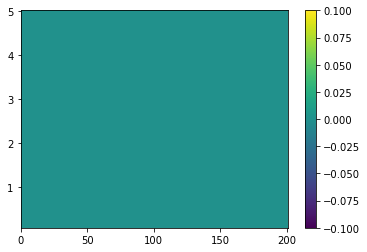

In [5]:
plt.pcolormesh(ww, ll, p, shading='auto')
plt.colorbar()

Lets evaluate the learning performance:

In [6]:
n_acc = 100
llb = 0.2
lub = 1.2
wlb = 50.
wub = 200.
portfolio = np.array([[np.random.uniform(llb, lub), np.random.uniform(wlb, wub)] for _ in range(n_acc)])

Text(0.5, 1.0, 'portfolio')

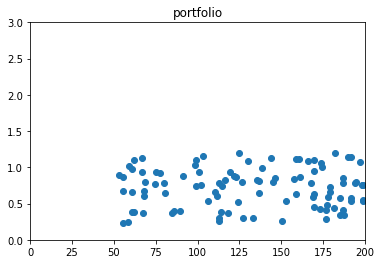

In [7]:
fig, ax = plt.subplots()
ax.scatter(portfolio[:, 1], portfolio[:, 0])
ax.set_ylim([0, 3])
ax.set_xlim([0, 200])
ax.set_title('portfolio')

In [8]:
import logging
import sys
from tqdm import tqdm
from joblib import delayed, Parallel
logging.getLogger().setLevel(logging.ERROR)

def calc_checkpoint_value(accs, checkpoint, niter= 5000, w_points = 100, l_points=100, lam_lim=5):
    res = np.zeros(len(accs), dtype='float64')
    agent = ldr.load_agent_from_path(checkpoint);
    sys.stdout.flush()
    ww, ll, p, z = policy_pricer.create_map(agent, w_points = w_points, l_points=l_points, lam_lim=lam_lim, larger_offset=True)
    for i, acc in enumerate(accs):
        vals = np.asarray(cython_pricer_optimized.value_account(acc, ww, ll, p, cython_pricer_optimized.convert_params_obj(agent.env.params), agent.env.env.action_bins, n_iterations=niter))
        res[i] = np.mean(vals)
    return np.mean(res), np.std(res)

def calc_agent(ldr, name, accs, log_num=0, niter= 5000, w_points = 100, l_points=100, lam_lim=5):
    checkpoint_paths = ldr.list_checkpoints(name, log_num=log_num)
    vals = np.zeros(len(checkpoint_paths))
    stds = np.zeros(len(checkpoint_paths))
    for i, path in enumerate(tqdm(checkpoint_paths)):
        vals[i], stds[i] = calc_checkpoint_value(accs, path, niter=niter, w_points = w_points, l_points=l_points, lam_lim=lam_lim)
    return vals, stds


def calc_agent_parallel(ldr, name, accs, log_num=0, niter= 5000, w_points = 100, l_points=100, lam_lim=5, n_jobs=20):
    checkpoint_paths = ldr.list_checkpoints(name, log_num=log_num)
#     vals = np.zeros(len(checkpoint_paths))
#     stds = np.zeros(len(checkpoint_paths))
    rets = Parallel(n_jobs=n_jobs)(delayed(calc_checkpoint_value)(accs, path, niter=niter, w_points = w_points, l_points=l_points, lam_lim=lam_lim) for path in checkpoint_paths)
    return rets

def value_names(ldr, names, accs, n_jobs=20, log_num=0, niter= 5000, w_points = 100, l_points=100, lam_lim=5):
    results = {}
    for i, name in enumerate(tqdm(names)):
        if n_jobs>1:
            results[name] = (calc_agent_parallel(ldr, name, accs, log_num=log_num, niter= niter, w_points = w_points, l_points=l_points, lam_lim=lam_lim, n_jobs=n_jobs))
        else:
            results[name] = (calc_agent(ldr, name, accs, log_num=log_num, niter=niter, w_points = w_points, l_points=l_points, lam_lim=lam_lim, n_jobs=n_jobs))
        save_obj(results, 'MC_5000_all_evaluated')
    return results
            
def save_obj(obj, name ):
    with open('obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [9]:
# AGENTS = ['DQN-0', 'SPLINE-0', 'MONOSPLINE-0']
AGENTS = os.listdir(os.path.join(ldr.repo, 'models'))[1:]

vals = value_names(ldr, AGENTS, portfolio, n_jobs=45, log_num=0, niter= 5000, w_points = 100, l_points=100, lam_lim=5)

100%|█████████████████████████████████████████████████████████████████████████████| 30/30 [16:21:00<00:00, 1962.01s/it]


In [14]:
len(vals.items())

30

In [26]:
vals.keys()

dict_keys(['DQN-0', 'DQN-1', 'DQN-2', 'DQN-3', 'DQN-4', 'DQN-5', 'DQN-6', 'DQN-7', 'DQN-8', 'DQN-9', 'MONOSPLINE-0', 'MONOSPLINE-1', 'MONOSPLINE-2', 'MONOSPLINE-3', 'MONOSPLINE-4', 'MONOSPLINE-5', 'MONOSPLINE-6', 'MONOSPLINE-7', 'MONOSPLINE-8', 'MONOSPLINE-9', 'SPLINE-0', 'SPLINE-1', 'SPLINE-2', 'SPLINE-3', 'SPLINE-4', 'SPLINE-5', 'SPLINE-6', 'SPLINE-7', 'SPLINE-8', 'SPLINE-9'])

In [27]:
'DQN'.startswith('DQ')

True

In [29]:
# THIS IS HOW TO LOOK IT UP LATER !
dqns = [ l for k,l in vals.items() if k.startswith('DQN')]
monosplines = [ l for k,l in vals.items() if k.startswith('SPLINE')]
bsplines = [ l for k,l in vals.items() if k.startswith('MONO')]

In [34]:
dqns[0]

500

In [122]:
def process_plot_data(vals, key: str):
    data_from_key = dqns = [ l for k,l in vals.items() if k.startswith(key)]
    avgs = np.zeros((len(data_from_key[0]), len(data_from_key)), dtype='float64')
    stds = np.zeros((len(data_from_key[0]), len(data_from_key)), dtype='float64')
    for i, teration in enumerate(data_from_key):
        avgs[:, i] = [data[0] for data in data_from_key[i]]
        stds[:, i] = [data[1] for data in data_from_key[i]]
    return avgs, stds

def plot_learning(names, vals):
    fig, ax = plt.subplots(figsize=(16, 8))
    x = np.arange(0, 50000, 100)
    for i, name in enumerate(names):
        avgs, stds = process_plot_data(vals, name)
        stds = np.std(avgs, axis=1)
        avgs = np.mean(avgs, axis=1)
        ax.plot(x, avgs)
        ax.fill_between(x, avgs-stds, avgs+stds, alpha=0.4)
    ax.legend(['DQN', 'Monotonic BSpline', 'BSpline'])
    ax.set_xlabel(['Learning steps'])
    ax.axhline(aav_portfolio(portfolio), color='red', linestyle='--')
    ax.axhline(v_s, color='brown', linestyle='--')
    
def aav_portfolio(portf):
    aav = AAV(ag.env.params)
    values = np.zeros(len(portf))
    for i, value in enumerate(portf):
        values[i] = aav.u(value[0], value[1])
    return -np.mean(values)

def compute_v(portf):
    # probably taking max of a portfolio would be better here
    oav = OAV(ag.env.params, 200)
    oav.solve_v()
    values = np.zeros(len(portf))
    for i, value in enumerate(portf):
        values[i] = oav.v(value[0], value[1])
    return -np.mean(values)

# v_s = compute_v(portfolio)

In [123]:
 aav_portfolio(portfolio)

[INFO] [2021-03-11 14:50:34,703] [AAV] - Instantiated @ AAV


68.06846559169973

[INFO] [2021-03-11 14:50:35,269] [AAV] - Instantiated @ AAV


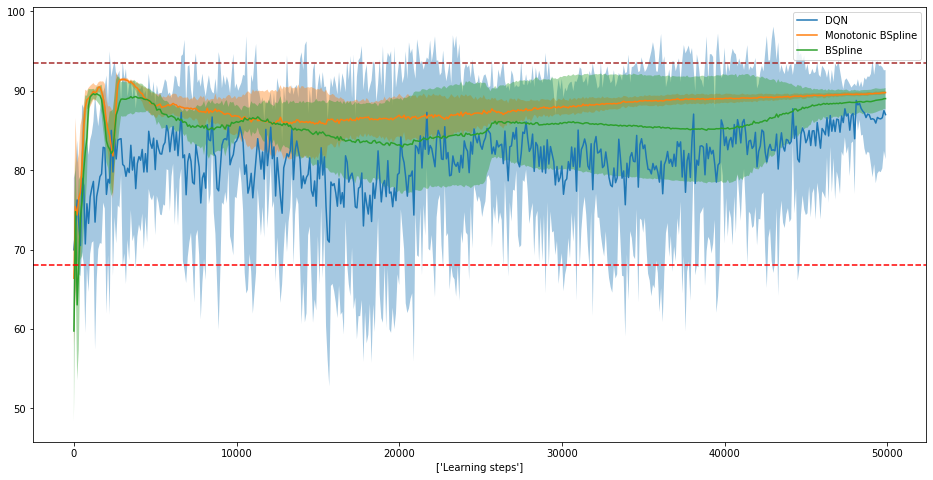

In [124]:
plot_learning(['DQN', 'SPLINE', 'MONO'], vals)


In [60]:
ag1 = [vals[0][i][0] for i in range(len(vals[0]))]
ag2 = [vals[1][i][0] for i in range(len(vals[0]))]
ag3 = [vals[2][i][0] for i in range(len(vals[0]))]

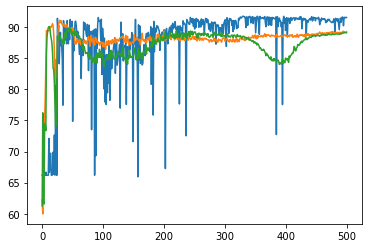

In [61]:
plt.plot(ag1)
plt.plot(ag2)
plt.plot(ag3)

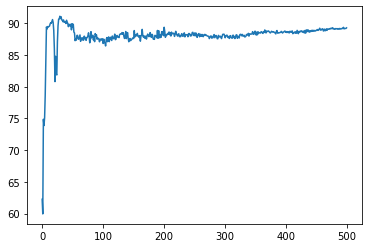

In [63]:
plt.plot(ag2)

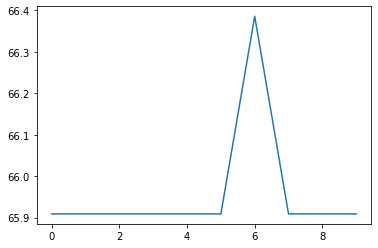

In [34]:
plt.plot([r[0] for r in rs[0:10]])

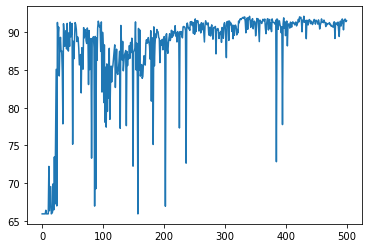

In [31]:
plt.plot([r[0] for r in rs])

In [15]:
vals, stds = calc_agent(ldr, 'DQN-0', portfolio, log_num=0, niter= 100, w_points = 100, l_points=100, lam_lim=5)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [22:38<00:00,  2.72s/it]


In [17]:
import time

In [20]:
now = time.time()

In [23]:
time.time() - now

19.337053537368774

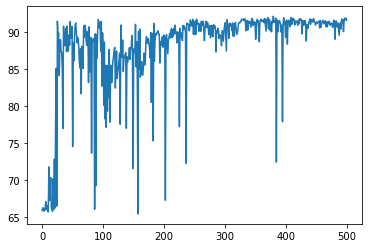

In [16]:
plt.plot(vals)

In [136]:
vals_naive = policy_pricer.value_account(np.array([0.2, 200]), ww, ll, p, ag.env.params, ag.env.env.action_bins, n_iterations=1000)

In [115]:
vals_pars = policy_pricer.value_account_parallel(np.array([0.2, 200]), ww, ll, p, ag.env.params, ag.env.env.action_bins, n_iterations=10000)

IndexError: index 100 is out of bounds for axis 0 with size 100

In [137]:
vals = np.asarray(cython_pricer_optimized.value_account(np.array([0.2, 200]), ww, ll, p, cython_pricer_optimized.convert_params_obj(ag.env.params), ag.env.env.action_bins, n_iterations=10000))

In [138]:
np.mean(vals)

116.13722292772543

In [139]:
np.mean(vals_naive)

111.26565

In [14]:
%%timeit
agent.main_net.predict_on_batch(converted[None, :])

1.92 ms ± 36.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [18]:
%%timeit
agent.main_net(converted[None, :])

313 µs ± 6.35 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [20]:
%%timeit
agent.main_net.predict(converted[None, :])

27.5 ms ± 1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [22]:
np.argmax(agent.main_net.predict(agent.env.observation(point)[None, :]))

2

In [145]:
import logging, sys
logging.disable(sys.maxsize)

def checkpoints_and_paths(name):
    # name = "Vanilla4ActionsSplines50K"
    log_path = os.path.join(misc.RESOURCE_ROOT, 'models', name)
    logs = os.listdir(log_path)
    print(logs)
    log_num = 1
    checkpoints_path = os.path.join(misc.RESOURCE_ROOT, 'models', name, logs[0], 'checkpoints')
    checkpoints = np.sort(np.array(os.listdir(checkpoints_path), dtype='int32'))
    checkpoints_paths = [os.path.join(misc.RESOURCE_ROOT, 'models', name, logs[0], 'checkpoints', str(pasorted)) for pasorted in checkpoints]
    return checkpoints_paths

def plot_learning_performance(names):
    checkpoint_paths = [checkpoints_and_paths(name) for name in names]
    accounts = np.array([[1. , 200],[1. , 100], [1. , 50]])
    values = np.zeros((len(checkpoints), accounts.shape[0], len(names)))
    actions = np.zeros((len(checkpoints), accounts.shape[0], len(names)))
    agentf = load_agent_from_path(checkpoints_paths[-1])
    trans_acc = agentf.env.observation(accounts)
    for i, cp in enumerate(tqdm(checkpoint_paths[0][:200])):
        for j, n in enumerate(names):
            agent = load_agent_from_path(checkpoint_paths[j][i])
            values[i, :, j] = np.amax(agent.main_net.predict_on_batch(trans_acc), axis=1)
            actions[i, :, j] = np.argmax(agent.main_net.predict_on_batch(trans_acc), axis=1)
    return values , actions

In [146]:
vals, actions = plot_learning_performance(["Vanilla4ActionsSplines50K", "Penalized4ActionsSplines50K"])


['20201215-215946', '20201215-215951']
['20201215-214758', '20201215-215926']


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:35<00:00,  2.10it/s]


Text(0.5, 1.0, 'Constrained vs NonConstrained')

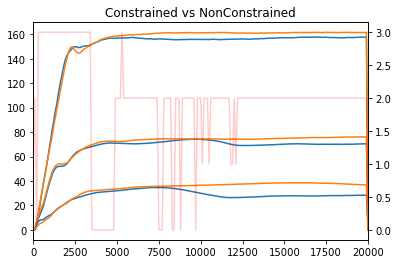

In [157]:
fig, ax = plt.subplots()
ax.plot(checkpoints, vals[:, 0, 0], color = 'C0')
ax.plot(checkpoints, vals[:, 0, 1], color = 'C1')
ax.plot(checkpoints, vals[:, 1, 0], color = 'C0')
ax.plot(checkpoints, vals[:, 1, 1], color = 'C1')
ax.plot(checkpoints, vals[:, 2, 0], color = 'C0')
ax.plot(checkpoints, vals[:, 2, 1], color = 'C1')
ax2 = ax.twinx()
ax2.plot(checkpoints, actions[:, 0, 0], color='red', alpha=0.2)
ax.set_xlim([0, 20000])
ax.set_title('Constrained vs NonConstrained')

In [125]:
import logging, sys
from tqdm import tqdm
logging.disable(sys.maxsize)

accounts = np.array([[1. , 200],[1. , 100], [1. , 50]])
values = np.zeros((len(checkpoints), accounts.shape[0]))
actions = np.zeros((len(checkpoints), accounts.shape[0]))
agentf = load_agent_from_path(checkpoints_paths[-1])
trans_acc = agentf.env.observation(accounts)
for i, cp in enumerate(tqdm(checkpoints)):
    agent = load_agent_from_path(checkpoints_paths[i])
    values[i, :] = np.amax(agent.main_net.predict_on_batch(trans_acc), axis=1)
    actions[i, :] = np.argmax(agent.main_net.predict_on_batch(trans_acc), axis=1)
    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:00<00:00,  4.16it/s]


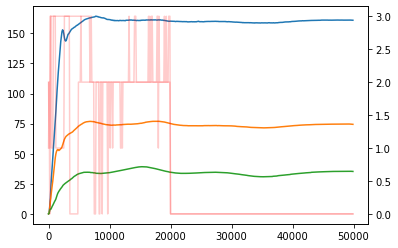

In [147]:
fig, ax = plt.subplots()
ax.plot(checkpoints, values[:, 0])
ax.plot(checkpoints, values[:, 1])
ax.plot(checkpoints, values[:, 2])
ax2 = ax.twinx()
ax2.plot(checkpoints, actions[:, 0], color='red', alpha=0.2)

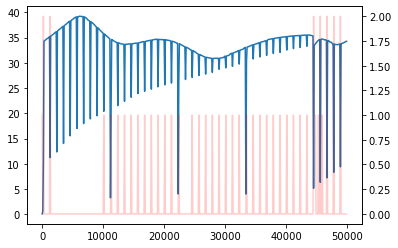

In [101]:
fig, ax = plt.subplots()
ax.plot(checkpoints, values[:, 1])
ax2 = ax.twinx()
ax2.plot(checkpoints, actions[:, 1], color='red', alpha=0.2)

In [ ]:
np.amax(agent.main_net.predict_on_batch(agent.env.observation(np.array([[1. , 100], [1. , 50]] ))), axis=1)

In [57]:
agent = load_agent_from_path(checkpoints_paths[2])

[INFO] [2021-02-04 12:50:13,158] [C:\Projects\credit_collections_rl\learning\resources\models\Vanilla4ActionsSplines50K\20201215-215951\checkpoints\1000] - Instantiated class DQNAgent
[WARNING] [2021-02-04 12:50:13,358] [tensorflow] - No training configuration found in the save file, so the model was *not* compiled. Compile it manually.
[WARNING] [2021-02-04 12:50:13,370] [tensorflow] - No training configuration found in the save file, so the model was *not* compiled. Compile it manually.


In [67]:
agent.env.observation(np.array([[1. , 100], [1. , 50]] ))

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.19624559e-02, 8.05528547e-03,
        7.98881254e-04, 1.67107415e-05, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 2.75136485e-01, 1.85271566e-01,
        1.83742688e-02, 3.84347055e-04, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 2.75136485e-01, 1.85271566e-01,
        1.83742688e-02, 3.84347055e-04, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.19624559e-02, 8.05528547e-03,
        7.98881254e-04, 1.67107415e-05, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.000000

In [72]:
np.amax(agent.main_net.predict_on_batch(agent.env.observation(np.array([[1. , 100], [1. , 50]] ))), axis=1)

array([42.100174, 10.450637], dtype=float32)

In [58]:
def create_map(agent, lam_lim=7):
    w_points = 80
    l_points = 80
    l = np.linspace(agent.env.observation_space.low[0], lam_lim, l_points)
    w = np.linspace(agent.env.observation_space.low[1], agent.env.observation_space.high[1], w_points)
    
#     w_normalized = np.linspace(0, 1, w_points)
#     l_normalized = np.linspace(0, agent.env.observation((lam_lim,100))[0], l_points)
#     wwn, lln = np.meshgrid(w_normalized, l_normalized)
    ww, ll = np.meshgrid(w, l)
    space_iterator = product(l, w)
    space_product = agent.env.observation(np.array([[i, j] for i, j in space_iterator]))
    predictions = agent.main_net.predict_on_batch(space_product)
    z = np.amax(predictions, axis=1).reshape(l_points, w_points)
    p = np.argmax(predictions, axis=1).reshape(l_points, w_points)
    return  ww, ll, p, z
#ww, ll, aa, z = create_map(agent)
ww, ll, p, z = create_map(agent)

Text(0.5, 1.0, 'Simplest default with labels')

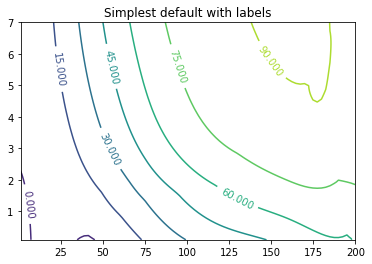

In [59]:
fig, ax = plt.subplots()
CS = ax.contour(ww, ll, z)
ax.clabel(CS, inline=1, fontsize=10)
ax.set_title('Simplest default with labels')